In [3]:
# %cd ~/src/DiscCaptioning/
# %run eval.py --decoding_constraint 1 --dump_images 0 --num_images -1 --batch_size 50 --split test  --input_label_h5 data/cocotalk_label.h5 --input_fc_dir data/cocotalk_fc --input_att_dir data/cocobu_att --model log_att_d1/model.pth --beam_size 5 --temperature 1.0 --sample_max 1 --infos_path log_att_d1/infos_att_d1.pkl

In [4]:
import datetime
import json
import pathlib

import pandas as pd
import numpy as np
import toolz
from IPython.display import Image, HTML

In [5]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util
reload(analysis_util), reload(util), reload(notebook_util)

Loading COCO captions
Loading COCO id2url
Done
Loading COCO captions
Loading COCO id2url
Done


(<module 'textrec.analysis_util' from '/Users/kcarnold/code/textrec/src/textrec/analysis_util.py'>,
 <module 'textrec.util' from '/Users/kcarnold/code/textrec/src/textrec/util.py'>,
 <module 'textrec.notebook_util' from '/Users/kcarnold/code/textrec/src/textrec/notebook_util.py'>)

In [17]:
from textrec.notebook_util import images, id2img, id2url, images_by_split, show_images

In [7]:
#vectorizer, valid_img_by_word = util.get_vectorized_captions(split='val')
cap_vectorizer, caption_vecs = util.get_vectorized_captions()

In [8]:
def get_similar_images(caption, n=10):
    query_vec = cap_vectorizer.transform([caption])
    similarity = caption_vecs.dot(query_vec.T).A.ravel()
    return [images[idx]['cocoid'] for idx in np.argsort(similarity)[-n:][::-1]]

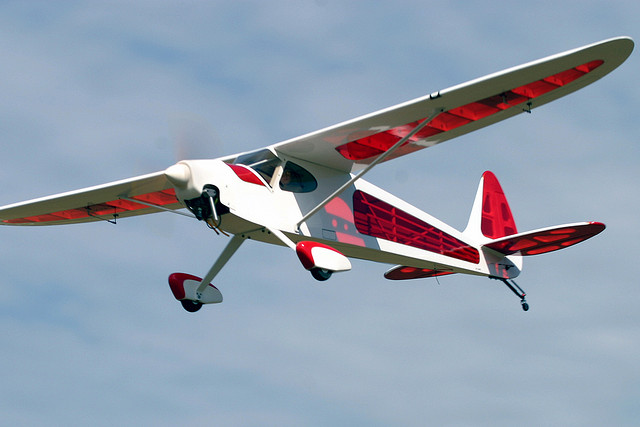

In [27]:
#Image(id2url[images_by_split['val'][50]['cocoid']])
Image(id2url[images_by_split['val'][20]['cocoid']])

In [31]:
# query_caption = 'a cat sitting on a'
# query_caption = 'a close up of two brown and white cows with mountains'
query_caption = 'a white and red plane flying towards us in front of a grey sky'
print(query_caption)
image_set = get_similar_images(query_caption)
HTML(show_images(image_set, show_captions=False, show_label=True, max_width=200))

a white and red plane flying towards us in front of a grey sky


# Generate a next-word recommendation that distinguishes one image from the rest

In [10]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import onmt.io

/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
from textrec import onmt_model_2
reload(onmt_model_2)

Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.


<module 'textrec.onmt_model_2' from '/Users/kcarnold/code/textrec/src/textrec/onmt_model_2.py'>

In [12]:
coco_cap = onmt_model_2.models['coco_cap']

In [13]:
import h5py
f = h5py.File(str(paths.imgdata_h5_all))

def load_vecs(imgids, num_objs=36, feature_dim=2048):
    batch_size = len(imgids)
    vecs = np.empty((num_objs, batch_size, feature_dim))
    for i, idx in enumerate(imgids):
        vecs[:, i, :] = f[str(idx)][:]
    return Variable(torch.FloatTensor(vecs), volatile=True)


def encode_vecs(self, vecs):
    # vecs: objs x batch_size x feature_dim
    mean_feature = torch.mean(vecs, dim=0)  # batch_size x feature_dim

    # Construct the hidden and cell states.
    hidden_state = F.tanh(self.init_hidden(mean_feature))
    cell_state = F.tanh(self.init_cell(mean_feature))
    # hidden_state: batch_size x rnn_size

    # To make this look like the output of a sequence RNN, states need to
    # have an extra first dimension (per decoder layer) and be packed in a
    # tuple.

    enc_final = (
        hidden_state.unsqueeze(0),
        cell_state.unsqueeze(0)
    )

    return enc_final, vecs

vecs = load_vecs(image_set)
encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)

In [14]:
def get_logits_multi(model, imgids, tgt_field, tgt_text):
    batch_size = len(imgids)

    vecs = load_vecs(imgids)
    encoder_final, memory_bank = encode_vecs(coco_cap.model.encoder, vecs)

    decoder_state = model.decoder.init_decoder_state(vecs, memory_bank=memory_bank, encoder_final=encoder_final)

    tgt_vocab = tgt_field.vocab
    tokens = [onmt.io.BOS_WORD] + onmt_model_2.tokenize(tgt_text)
    print(tokens)
    tgt = Variable(torch.LongTensor([tgt_vocab.stoi[tok] for tok in tokens])).unsqueeze(1)
    tgt = tgt.expand(-1, len(imgids)).unsqueeze(2)
    
    dec_out, dec_states, attn = model.decoder(tgt, memory_bank, decoder_state)
    logits = model.generator(dec_out).contiguous()
    return logits[-1]

tgt_field = coco_cap.fields['tgt']
all_logits = get_logits_multi(
    coco_cap.model,
    image_set,
    tgt_field,
    query_caption
).data.numpy()


['<s>', 'a', 'cat', 'sitting', 'on', 'a']


In [15]:
all_logits.shape

(10, 25029)

In [89]:
onmt_model_2.get_top_k(torch.Tensor(all_logits[0]), tgt_field.vocab.itos, 3)

[('balcony', -0.4444151222705841),
 ('window', -2.4897727966308594),
 ('patio', -3.150484085083008)]

In [2]:
from scipy.special import logsumexp

In [1]:
likelihood_bias = logsumexp(all_logits, axis=0, keepdims=True)
amped_logits = all_logits - 1. * likelihood_bias
#onmt_model_2.get_top_k(torch.Tensor(amped_logits[0]), tgt_field.vocab.itos, 3)

likelihood_bias.shape

NameError: name 'logsumexp' is not defined

In [119]:
html = ''

for idx, img_idx in enumerate(image_set):
    topks_plain = onmt_model_2.get_top_k(torch.Tensor(all_logits[idx]), tgt_field.vocab.itos, 3)
    topks_amp = onmt_model_2.get_top_k(torch.Tensor(amped_logits[idx]), tgt_field.vocab.itos, 3)
    url = id2url[id2img[img_idx]['cocoid']]
    label_amp = ', '.join(word for word, prob in topks_amp)
    html += '<div style="display: inline-block;"><img src="{}" style="max-width: 200px;"><div>{}</div><div>{}</div></div>'.format(
        url,
        ', '.join(word for word, prob in topks_amp),
        ', '.join(word for word, prob in topks_plain))
#     print('\n'.join(f'{prob:0.2f} {word}' for word, prob in topk))    
#     print('\n'.join(f'{prob:0.2f} {word}' for word, prob in topk))
HTML(html)

In [101]:
for tgt_img in range(10):
    print()
    print(tgt_img)
    topk = onmt_model_2.get_top_k(torch.Tensor(all_logits[tgt_img]), tgt_field.vocab.itos, 3)
    print('\n'.join(f'{prob:0.2f} {word}' for word, prob in topk))
    
    topk = onmt_model_2.get_top_k(torch.Tensor(amped_logits[tgt_img]), tgt_field.vocab.itos, 3)
    print('\n'.join(f'{prob:0.2f} {word}' for word, prob in topk))



0
-0.44 balcony
-2.49 window
-3.15 patio
-0.00 balcony
-0.02 carnival
-0.03 gated

1
-0.60 chair
-2.60 couch
-2.67 pillow
-0.02 watercrafts
-0.05 morror
-0.06 yarn

2
-0.67 laptop
-2.12 desk
-2.77 computer
-0.00 online
-0.01 midi
-0.01 easy-chair

3
-1.06 wooden
-1.75 bench
-1.99 red
-0.02 pipes
-0.02 motorized
-0.02 development

4
-1.69 counter
-2.08 table
-2.25 sink
-0.04 razor
-0.04 bucked
-0.04 plumber

5
-0.78 table
-1.15 chair
-3.23 dining
-0.02 steaming
-0.06 dinning
-0.07 dinnerware

6
-1.66 desk
-2.41 table
-2.66 bed
-0.00 texter
-0.00 project
-0.00 crocheting

7
-0.58 chair
-2.73 wooden
-2.77 desk
-0.03 swiveling
-0.03 accommodations
-0.06 make-shift

8
-1.34 pink
-2.45 bed
-2.80 white
-0.01 duffel
-0.03 committing
-0.04 make-up

9
-0.57 couch
-1.81 bed
-2.40 chair
-0.02 animal-shaped
-0.02 knick-knack
-0.02 forsythia


In [82]:
logsumexp(all_logits[0])

-1.1920929e-07

In [83]:
likelihood_bias.shape

(10, 1)